In [15]:
import os
import sys; sys.path.append("~/HHbbgg_ETH/Training/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)

<module 'training_utils' from '/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/Training/python/training_utils.py'>

In [3]:
ntuples = '20170509'
# "%" sign allows to interpret the rest as a system command
%env data=$utils.IO.ldata$ntuples
files = ! ls $data | sort -t_ -k 3 -n
signal = [s for s in files if "NonRes" in s]
background = [s for s in files if "DiPhotonJets" in s]

utils.IO.set_signal_and_background(ntuples,signal,background)

print "using background file:"+utils.IO.backgroundName
print "using signal file:"+utils.IO.signalName

env: data=/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170509
using background file:/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170509/output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root
using signal file:/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170509/AllNonResSig.root


In [7]:
#normal variables: int, float, vectors...
branch_names = 'leadingJet_bDis,subleadingJet_bDis,CosThetaStar_CS,CosTheta_bb,CosTheta_gg,noexpand:diphotonCandidate.Pt(),noexpand:dijetCandidate.Pt(),noexpand:diHiggsCandidate.M()'.split(",")
branch_names = [c.strip() for c in branch_names]
branch_names = (b.replace(" ", "_") for b in branch_names)
branch_names = list(b.replace("-", "_") for b in branch_names)
print branch_names


#tlorentz vectors
branch_names_lorentz = 'diphotonCandidate,dijetCandidate,diHiggsCandidate'.split(",")
branch_names_lorentz = [c.strip() for c in branch_names_lorentz]
branch_names_lorentz = (b.replace(" ", "_") for b in branch_names_lorentz)
branch_names_lorentz = list(b.replace("-", "_") for b in branch_names_lorentz)
print branch_names_lorentz

#variables we want to access in tlorenz vector
branch_names_lorentz_var = 'Pt(),M()'.split(",")
branch_names_lorentz_var = [c.strip() for c in branch_names_lorentz_var]
branch_names_lorentz_var = (b.replace(" ", "_") for b in branch_names_lorentz_var)
branch_names_lorentz_var = list(b.replace("-", "_") for b in branch_names_lorentz_var)
print branch_names_lorentz_var

['leadingJet_bDis', 'subleadingJet_bDis', 'CosThetaStar_CS', 'CosTheta_bb', 'CosTheta_gg', 'noexpand:diphotonCandidate.Pt()', 'noexpand:dijetCandidate.Pt()', 'noexpand:diHiggsCandidate.M()']
['diphotonCandidate', 'dijetCandidate', 'diHiggsCandidate']
['Pt()', 'M()']


In [9]:
import pandas as pd
import root_pandas as rpd
#reload(pd)
#reload(rpd)
print "name"+utils.IO.signalName

#signal_df = rpd.read_root_LorentzVector(utils.IO.signalName,"bbggSelectionTree", columns = branch_names, columns_lorentz=branch_names_lorentz,columns_lorentz_var=branch_names_\
#lorentz_var)
signal_df = rpd.read_root(utils.IO.signalName,"bbggSelectionTree", columns = branch_names)
background_df = rpd.read_root(utils.IO.backgroundName,"bbggSelectionTree", columns = branch_names)
#example for converting files into csv. useful for plotting
#signal_df.to_csv('/tmp/micheli/prova.csv',',',mode='w')

name/mnt/t3nfs01/data01/shome/micheli/HHbbgg_ETH/root_files/20170509/AllNonResSig.root


In [10]:
#test the method with the best score

from sklearn import ensemble
import xgboost as xgb

utils.preprocessing.adjust_and_compress(signal_df).to_hdf('/tmp/micheli/signal.hd5','sig',compression=9,complib='bzip2',mode='w')
utils.preprocessing.adjust_and_compress(background_df).to_hdf('/tmp/micheli/background.hd5','bkg',compression=9,complib='bzip2',mode='w')

utils.preprocessing.define_process_weight(signal_df,1,1)
utils.preprocessing.define_process_weight(background_df,0,1)

shuffle = True
if shuffle:
            signal_df['random_index'] = np.random.permutation(range(signal_df.index.size))
            background_df['random_index'] = np.random.permutation(range(background_df.index.size))
        
            signal_df.sort_values(by='random_index',inplace=True)
            background_df.sort_values(by='random_index',inplace=True)
    

y_sig = signal_df[['proc']]
y_bkg = background_df[['proc']]




y_total_train = utils.preprocessing.get_total_training_sample(y_sig,y_bkg).ravel()


X_sig= np.concatenate([signal_df[['leadingJet_bDis','subleadingJet_bDis']],
                             np.divide(signal_df[['diphotonCandidate.Pt()']],signal_df[['diHiggsCandidate.M()']]),
                             np.divide(signal_df[['dijetCandidate.Pt()']],signal_df[['diHiggsCandidate.M()']]),
                             np.absolute(signal_df[['CosThetaStar_CS']]),
                             np.absolute(signal_df[['CosTheta_bb']]),
                             np.absolute(signal_df[['CosTheta_gg']])],
                             axis=1)

X_bkg = np.concatenate([background_df[['leadingJet_bDis','subleadingJet_bDis']],
                             np.divide(background_df[['diphotonCandidate.Pt()']],background_df[['diHiggsCandidate.M()']]),
                             np.divide(background_df[['dijetCandidate.Pt()']],background_df[['diHiggsCandidate.M()']]),
                             np.absolute(background_df[['CosThetaStar_CS']]),
                             np.absolute(background_df[['CosTheta_bb']]),
                             np.absolute(background_df[['CosTheta_gg']])],
                             axis=1)

X_total_train = utils.preprocessing.get_total_training_sample(pd.DataFrame(X_sig),pd.DataFrame(X_bkg))
X_total_test = utils.preprocessing.get_total_test_sample(pd.DataFrame(X_sig),pd.DataFrame(X_bkg))
y_total_test = utils.preprocessing.get_total_test_sample(pd.DataFrame(y_sig),pd.DataFrame(y_bkg))

clf = xgb.XGBClassifier(max_depth=10,learning_rate=0.2,n_estimators=500, min_child_weight=1e-5, nthread= 12)
#clf = ensemble.GradientBoostingClassifier(max_depth=10,learning_rate=0.1,n_estimators=200,verbose=1)
clf.fit(X_total_train,y_total_train)


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=10,
       min_child_weight=1e-05, missing=None, n_estimators=500, nthread=12,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

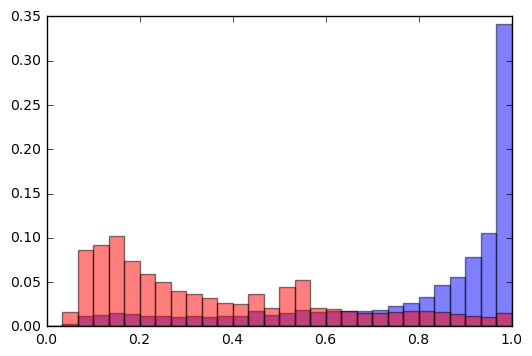

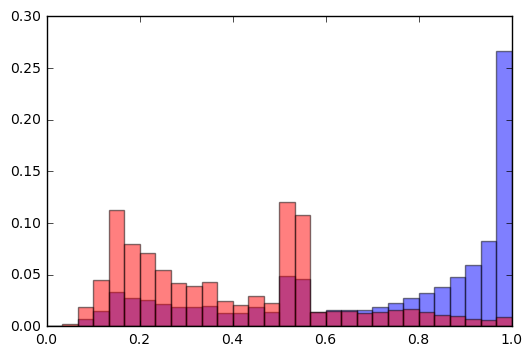

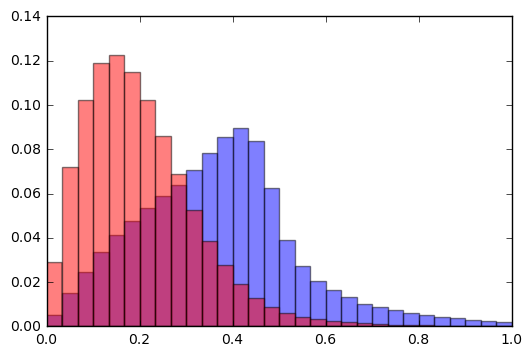

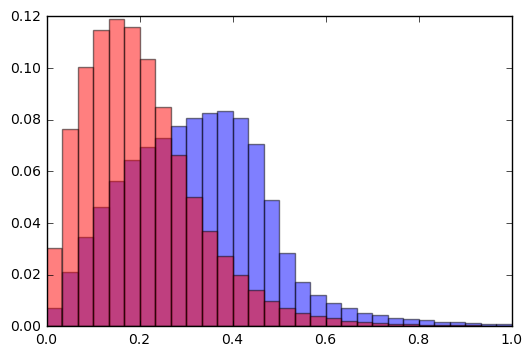

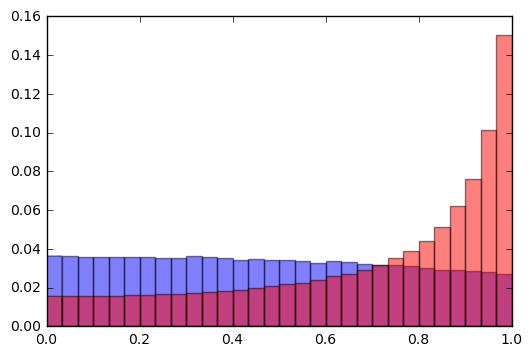

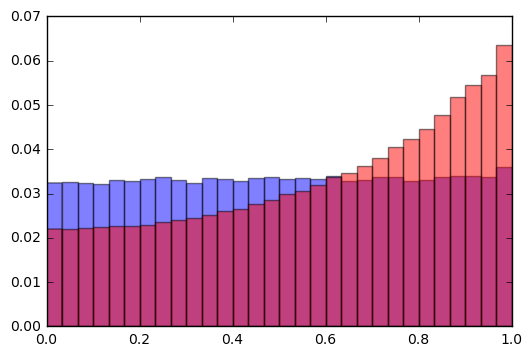

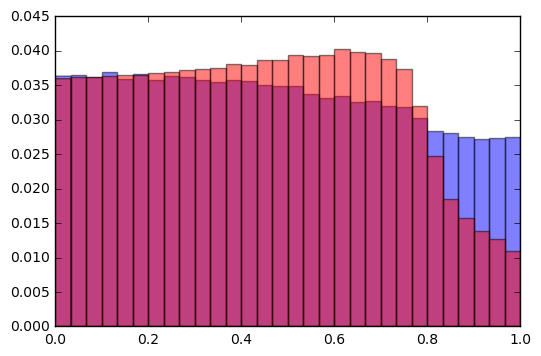

In [11]:
utils.plotting.plot_input_variables(X_sig,X_bkg)      

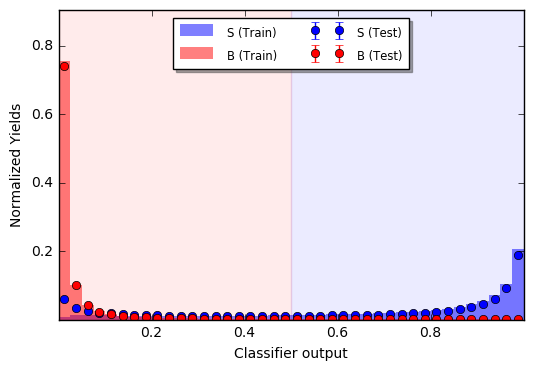

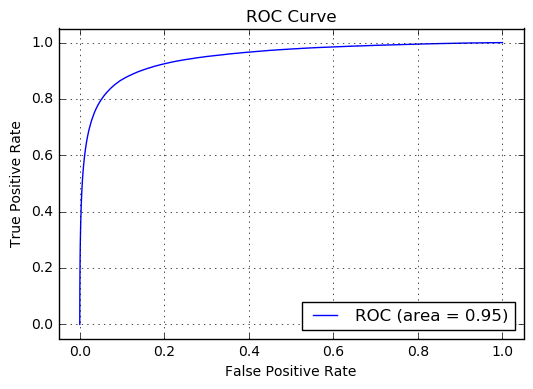

In [17]:
import matplotlib.pyplot as plt
X_total_test = utils.preprocessing.get_total_test_sample(pd.DataFrame(X_sig),pd.DataFrame(X_bkg))
y_total_test = utils.preprocessing.get_total_test_sample(pd.DataFrame(y_sig),pd.DataFrame(y_bkg)).ravel()

utils.plotting.plot_classifier_output(clf,X_total_train,X_total_test,y_total_train,y_total_test,outString="xbrg")
plt.show()
utils.plotting.plot_roc_curve(X_total_test,y_total_test,clf,"xgbr")
plt.show()